<a href="https://colab.research.google.com/github/anaguilarar/Crop_DL/blob/main/Rice_seeds_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To boost the process, please use gpu, habilitate the option in:
 runtime -> change runtime type -> hardware accelerator -> gpu . 

In [1]:
import os
if not os.path.exists("Crop_DL"):
    !git clone https://github.com/anaguilarar/Crop_DL.git
    print("Cloned")
    
else:
    print("crop_dl directory already exists")
if not os.getcwd().endswith("Crop_DL"):
  os.chdir("Crop_DL")

Cloning into 'Crop_DL'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 106 (delta 23), reused 96 (delta 17), pack-reused 0
Receiving objects: 100% (106/106), 1.14 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Cloned


In [2]:
from crop_dl.seeds.rice_counting import RiceSeedsCounting
from crop_dl.models.dl_initilizer import DLInstanceModel
from crop_dl.models.utils import check_weigth_path, downloadzip

import matplotlib.pyplot as plt
import torch
import os

### Configuration

Here the user defines the folder's name that contains the images that will be analyzed.
Likewise, the model will be updated with a pre-trained version. this version is stored in an amazon bucket


In [3]:
IMAGESPATH = "example_imagery/seeds"
WEIGHTSURL= "https://dlmodels-bucket.s3.ap-northeast-1.amazonaws.com/maskrcnn_rice_seeds.zip"

WEIGHTSPATH = check_weigth_path(WEIGHTSURL, suffix="checkpoint", weights_path="model_weights")


['maskrcnn_rice_seeds_20230308-000041/checkpoint']


### Setting the model and datasets


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

seed_model = DLInstanceModel(WEIGHTSPATH,
                 device = device)

ricecounts = RiceSeedsCounting(
                 IMAGESPATH,
                 seed_model.model, 
                 imagessuffix = ".jpg",
                 device = device)

print("files available in folder: ",ricecounts.listfiles)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

weights loaded
files available in folder:  ['test5.jpg', 'test3.jpg', 'test2.jpg', 'test10.jpg', 'test7.jpg', 'test.jpg', 'test4.jpg', 'test8.jpg', 'test6.jpg', 'test9.jpg']


### Detecting the rice seeds for an specific image

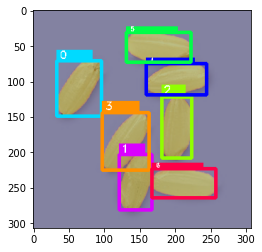

In [9]:
img_number = 1
ricecounts.detect_rice(img_number, keepsize=True, segment_threshold = 170)
m = ricecounts.plot_prediction(only_image=True)
plt.imshow(m[:,:,[2,1,0]])

#### Extracting information for a single seed

{'fn': ['test3.jpg'], 'seed_id': [6], 'height': [89.0], 'width': [40.0], 'area': [3119.0]}


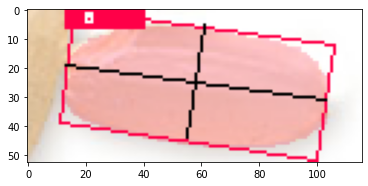

In [10]:
seed_number = 6
m = ricecounts.plot_individual_seed(seed_number)
print(ricecounts.calculate_oneseed_metrics(seed_number))
plt.imshow(m[:,:,[2,1,0]])

#### Extracting information for all seeds

In [18]:
filename = "{}_data.csv".format(
    ricecounts.listfiles[ricecounts.idimg][:ricecounts.listfiles[ricecounts.idimg].index(".jpg")])

df = ricecounts.one_image_seeds_summary()
df.to_csv(filename)
print(f"the data was saved in {filename}")
df


the data was saved in test3_data.csv


,fn,seed_id,height,width,area
0,test3.jpg,0,89.358827,38.587563,3023.0
0,test3.jpg,1,81.908486,39.560081,2788.0
0,test3.jpg,2,84.000000,41.000000,3038.0
0,test3.jpg,3,91.787799,39.824616,3191.0
0,test3.jpg,4,83.000000,43.000000,3036.0
0,test3.jpg,5,90.000000,40.000000,3210.0
0,test3.jpg,6,89.000000,40.000000,3119.0


#### Extracting the data for all the files that are inside the folder

In [19]:
filename = "all_data.csv"
df = ricecounts.all_image_seeds_summary()
df.to_csv(filename)
df

,fn,seed_id,height,width,area
0,test5.jpg,0,123.987903,35.468296,3969.0
0,test5.jpg,1,37.483330,36.769553,4194.0
0,test5.jpg,2,123.308556,34.132096,3761.0
0,test5.jpg,3,36.249138,33.615473,3137.0
0,test5.jpg,4,122.886126,32.202484,3468.0
...,...,...,...,...,...
0,test9.jpg,0,33.286634,18.601075,570.0
0,test9.jpg,1,36.000000,30.000000,988.0
0,test9.jpg,2,32.202484,17.000000,522.0
0,test9.jpg,3,29.000000,28.000000,814.0


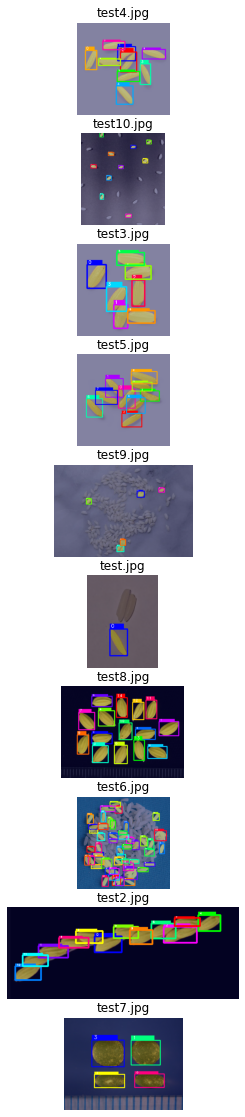

In [ ]:
images = ricecounts.all_image_predictions()

f, ax = plt.subplots(nrows=len(images), ncols=1, figsize = (10,20))

for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].set_axis_off()
    ax[i].set_title(ricecounts.listfiles[i])